## Import Modules

In [45]:
# import tensorflow_datasets as tfds
import tensorflow as tf
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil,floor
from IPython.display import clear_output
import gc

plt.style.use('fivethirtyeight')

data_dir = "/home/alkhemi/Documents/thesis/npy_data_s19_mfcc39_landmark107_pastX12_futureX12_pastY0_futureY0/"
model_dir = "/home/alkhemi/Documents/thesis/saved_model/"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Get data


In [46]:
# load data. input is a seq. output is single step data
# TODO multi speaker data load
X_train = np.load(data_dir+"X_train.npy")
Y_train = np.load(data_dir+"Y_train.npy")
X_test = np.load(data_dir+"X_test.npy")
Y_test = np.load(data_dir+"Y_test.npy")
print("train", "X shape:", X_train.shape, "Y shape:", Y_train.shape)
print("test", "X shape:", X_test.shape, "Y shape:", Y_test.shape)
# print("train", "x min:", X_train.min(), "x max:", X_train.max())
# print("train", "y min:", Y_train.min(), "y max:", Y_train.max())

train X shape: (138591, 25, 39) Y shape: (138591, 1, 107)
test X shape: (15400, 25, 39) Y shape: (15400, 1, 107)


In [ ]:
# one time only
def get_scaler_coef(arr,min,max):
  a = (max-min)/(arr.max()-arr.min())
  b = min-(max-min)*arr.min()/(arr.max()-arr.min())
  return a, b

def custom_scale(arr,a,b):
  return arr*a + b

def custom_inverse_scale(arr,a,b):
  return (arr-b)/a

x_scale_coefs = np.zeros(shape=(X_train.shape[2],2),dtype="float16")
y_scale_coefs = np.zeros(shape=(Y_train.shape[2],2),dtype="float16")
X_train_scaled = np.zeros(shape=X_train.shape,dtype="float16")
Y_train_scaled = np.zeros(shape=Y_train.shape,dtype="float16")
X_test_scaled = np.zeros(shape=X_test.shape,dtype="float16")
Y_test_scaled = np.zeros(shape=Y_test.shape,dtype="float16")

for i in range(X_train.shape[2]):
  x_scale_coefs[i] = np.array(get_scaler_coef(arr=X_train[:,:,i],min=-0.7,max=0.7))
  X_train_scaled[:,:,i] = custom_scale(X_train[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1] )
  X_test_scaled[:,:,i] = custom_scale(X_test[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1])
  
for i in range(Y_train.shape[2]):
  y_scale_coefs[i] = np.array(get_scaler_coef(arr=Y_train[:,:,i],min=-0.7,max=0.7))
  Y_train_scaled[:,:,i] = custom_scale(Y_train[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1] )
  Y_test_scaled[:,:,i] = custom_scale(Y_test[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1] )
  


pd.DataFrame(x_scale_coefs, columns=["a","b"]).to_csv(data_dir+"x_scale_coef.csv", index=False)
pd.DataFrame(y_scale_coefs, columns=["a","b"]).to_csv(data_dir+"y_scale_coef.csv", index=False)

print("train")
print("x min:", X_train_scaled.min(), "x max:", X_train_scaled.max())
print("y min:", Y_train_scaled.min(), "y max:", Y_train_scaled.max())
print("test")
print("x min:", X_test_scaled.min(), "x max:", X_test_scaled.max())
print("y min:", Y_test_scaled.min(), "y max:", Y_test_scaled.max())


In [47]:
def custom_scale(arr,a,b):
  return arr*a + b

def custom_inverse_scale(arr,a,b):
  return (arr-b)/a

x_scale_coefs = pd.read_csv(data_dir+"x_scale_coef.csv").to_numpy(dtype='float16')
y_scale_coefs = pd.read_csv(data_dir+"y_scale_coef.csv").to_numpy(dtype='float16')

X_train_scaled = np.zeros(shape=X_train.shape,dtype="float16")
Y_train_scaled = np.zeros(shape=Y_train.shape,dtype="float16")
X_test_scaled = np.zeros(shape=X_test.shape,dtype="float16")
Y_test_scaled = np.zeros(shape=Y_test.shape,dtype="float16")

for i in range(X_train.shape[2]):
  X_train_scaled[:,:,i] = custom_scale(
    X_train[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1])
  X_test_scaled[:,:,i] = custom_scale(
    X_test[:,:,i],x_scale_coefs[i,0],x_scale_coefs[i,1])
for i in range(Y_train.shape[2]):
  Y_train_scaled[:,:,i] = custom_scale(
      Y_train[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1])
  Y_test_scaled[:,:,i] = custom_scale(
      Y_test[:,:,i],y_scale_coefs[i,0],y_scale_coefs[i,1])


# print("train")
# print("x min:", X_train_scaled.min(), "x max:", X_train_scaled.max())
# print("y min:", Y_train_scaled.min(), "y max:", Y_train_scaled.max())
# print("test")
# print("x min:", X_test_scaled.min(), "x max:", X_test_scaled.max())
# print("y min:", Y_test_scaled.min(), "y max:", Y_test_scaled.max())

In [48]:

del X_train, Y_train, X_test, Y_test
print(gc.get_count())
print(gc.collect())
print(gc.get_count())

(71, 1, 22)
61025
(32, 0, 0)


In [49]:
print(X_train_scaled.shape, Y_train_scaled.shape)
print(X_test_scaled.shape, Y_test_scaled.shape)

(138591, 25, 39) (138591, 1, 107)
(15400, 25, 39) (15400, 1, 107)


In [ ]:
# batch_size = 1024
# train_dataset=[]
# for i in range(ceil(X_train_scaled.shape[0]/batch_size)):
#   pos = i*batch_size
#   train_dataset.append((X_train_scaled[pos:pos+batch_size],Y_train_scaled[pos:pos+batch_size]))

# # for testing single big batch
# test_dataset = []
# for i in range(ceil(X_test_scaled.shape[0]/batch_size)):
#   pos = i*batch_size
#   test_dataset.append((X_test_scaled[pos:pos+batch_size],Y_test_scaled[pos:pos+batch_size]))

# del X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled
# # train_dataset[0].shape, train_dataset[1].shape, test_dataset[0].shape, test_dataset[1].shape

In [ ]:
# len(test_dataset)

## Positional Encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [50]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    
    self.angle_rads = self.get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model)
    
    # apply sin to even indices in the array; 2i
    self.angle_rads[:, 0::2] = np.sin(self.angle_rads[:, 0::2])
    
    # apply cos to odd indices in the array; 2i+1
    self.angle_rads[:, 1::2] = np.cos(self.angle_rads[:, 1::2])
      
    self.pos_encoding = tf.cast(self.angle_rads[np.newaxis, ...], dtype=tf.float32)
  
  def get_angles(self, pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

  def call(self, x):    
    seq_len = tf.shape(x)[1]
    return x+self.pos_encoding[:, :seq_len, :]

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [51]:
def scaled_dot_product_attention(q, k, v):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk =tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # # add the mask to the scaled tensor.
  # if mask is not None:
  #   scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [52]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model, activation='linear')
    self.wk = tf.keras.layers.Dense(d_model, activation='linear')
    self.wv = tf.keras.layers.Dense(d_model, activation='linear')
    
    self.dense = tf.keras.layers.Dense(d_model, activation='linear')
          
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [53]:
def point_wise_feed_forward_network( d_model ,dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='tanh'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model, activation='linear')  # (batch_size, seq_len, d_model)
  ])

## Encoder 

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [54]:
class MultiHeadAttentionSubLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttentionSubLayer, self).__init__()
    self.mha = MultiHeadAttention(d_model, num_heads)     
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
  def call(self, x):
    attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
    return self.layernorm1(x + attn_output) # (batch_size, input_seq_len, d_model)

In [55]:
class FeedForwardNetworkSubLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, dff):
    super(FeedForwardNetworkSubLayer, self).__init__()
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
  def call(self, x):
    ffn_output = self.ffn(x)  # (batch_size, input_seq_len, d_model)
    return self.layernorm2(x + ffn_output)  # (batch_size, input_seq_len, d_model)

In [56]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff):
    super(Encoder, self).__init__()
    self.mha_sublayer = MultiHeadAttentionSubLayer(d_model, num_heads) 
    self.ffn_sublayer = FeedForwardNetworkSubLayer(d_model, dff)    
    
  def call(self, x):
    out1 = self.mha_sublayer(x)  # (batch_size, input_seq_len, d_model)
    out2 = self.ffn_sublayer(out1) # (batch_size, input_seq_len, d_model)
    return out2

## Metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [57]:
metrics = [    
           tf.keras.metrics.MeanSquaredError(),
           tf.keras.metrics.RootMeanSquaredError(),
           tf.keras.metrics.MeanAbsoluteError(),
           tf.keras.metrics.MeanAbsolutePercentageError(),
           tf.keras.metrics.MeanSquaredLogarithmicError(),
           tf.keras.metrics.CosineSimilarity(axis=2),
]

## Callback

In [58]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, model_name, save_dir="./"):
    # self.model = model
    self.save_dir = save_dir
    self.model_name = model_name
    self.on_train_begin
  def on_train_begin(self, logs={}):
    if os.path.exists(self.save_dir+self.model_name+'-history.csv'):
      hist_df = pd.read_csv(self.save_dir+self.model_name+'-history.csv')
      self.i = hist_df["epoch"].values.tolist()[-1] +1
      self.x = hist_df["epoch"].values.tolist()
      self.timestamp=hist_df["timestamp"].values.tolist()
      self.time_offset = hist_df["timestamp"].values.tolist()[-1]

      self.metrics = {}
      for key in hist_df.keys():
        if key != 'epoch' and key != 'timestamp':
          self.metrics[key] = hist_df[key].values.tolist()     
      
    else:
      self.i = 1
      self.x = []
      self.timestamp=[]
      self.time_offset = 0

      self.metrics = {}

      
    self.fig = plt.figure()
    self.logs = []
    self.st_time=time.time()

  def on_epoch_end(self, epoch, logs={}):       
    self.logs.append(logs)
    self.x.append(self.i)
    self.i += 1
    self.timestamp.append(time.time()-self.st_time+self.time_offset)

    for key in logs.keys():
      if self.metrics.get(key) == None:
        self.metrics[key] = [logs[key]]
      else:  
        self.metrics[key].append(logs.get(key))
    
    # print("saving model")
    # subclassed model can only save weights
    self.model.save_weights(
      f'{self.save_dir+self.model_name}-{self.x[-1]:02d}'
      f'-{logs["val_loss"]:.4f}.h5')
      # f'-{logs["val_cosine_similarity"]:.4f}.h5')

    # print("saving history")
    hist_df = pd.DataFrame()
    hist_df["epoch"]=self.x
    hist_df["timestamp"]=self.timestamp

    for key in logs.keys():
      hist_df[key] = self.metrics[key]
    hist_df.to_csv(self.save_dir+self.model_name+'-history.csv',index=False)

    clear_output(wait=True)


    # keys = [key for key in self.metrics.keys() if key[0:4] != "val_"]
    # metrics_count = len(keys)
    # f, ax = plt.subplots(ceil(metrics_count/2), 2, sharex=True, figsize=(25,5*ceil(metrics_count/2)))
    
    # for i, key in enumerate(keys):
    #   r = floor(i/2)
    #   c = i%2
    #   ax[r,c].set_yscale('log')  
    #   ax[r,c].set_title(key)
    #   ax[r,c].set_xlabel("epoch")
    #   ax[r,c].plot(self.x, self.metrics[key], label=key)
    #   ax[r,c].plot(self.x, self.metrics["val_"+key], label="val_"+key)
    #   ax[r,c].legend()
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,5))
   
    ax1.set_yscale('log')
    ax1.set_title("Loss: Mean Squared Error")
    ax1.set_xlabel("epoch")
    ax1.plot(self.x, self.metrics["loss"], label="loss")
    ax1.plot(self.x, self.metrics["val_loss"], label="val_loss")
    ax1.legend()

    ax2.set_title("Cosine Similarity")
    ax2.set_xlabel("epoch")
    ax2.plot(self.x, self.metrics["cosine_similarity"], label="cosine_similarity")
    ax2.plot(self.x, self.metrics["val_cosine_similarity"], label="val_cosine_similarity")
    ax2.legend()
    
    plt.show();
    print("time elapsed:", time.time()-self.st_time)

## Create Model

In [61]:
model_name = "Attention64_s19_mha1_numheads8_ffn1_dff256_batch64_seq12-12-0-0"
d_model = 64
num_heads = 8
dff = 256
batch_size = 64
save_dir = model_dir+model_name+"/"
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

with tf.device('/gpu:0'):
  model = tf.keras.Sequential(
      name= model_name,
      layers=[
              tf.keras.layers.InputLayer((X_train_scaled.shape[1],X_train_scaled.shape[2]), dtype='float32'),
              tf.keras.layers.Dense(d_model, activation='tanh'),
              PositionalEncoding(position=X_train_scaled.shape[1],d_model=d_model),
              MultiHeadAttentionSubLayer(d_model=d_model,num_heads=num_heads),
              FeedForwardNetworkSubLayer(d_model=d_model,dff=dff),
              tf.keras.layers.Reshape((Y_train_scaled.shape[1],d_model*X_train_scaled.shape[1])),
              tf.keras.layers.Dense(Y_train_scaled.shape[2], activation='linear')
  ])
  

  model.summary()

  custom_callback = CustomCallback(model_name=model_name,save_dir=save_dir)
  model.compile(
      optimizer='adam',
      loss='mse',
      metrics=metrics,
      )

Model: "Attention64_s19_mha1_numheads8_ffn1_dff256_batch64_seq12-12-0-0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 25, 64)            2560      
_________________________________________________________________
positional_encoding_7 (Posit (None, 25, 64)            0         
_________________________________________________________________
multi_head_attention_sub_lay (None, 25, 64)            16768     
_________________________________________________________________
feed_forward_network_sub_lay (None, 25, 64)            33216     
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 1600)           0         
_________________________________________________________________
dense_51 (Dense)             (None, 1, 107)            171307    
Total params: 223,851
Trainable params: 223,851
Non-trainable params:

## Load Trained Model

In [ ]:
# model_name = "Attention64"
# save_dir = "/home/alkhemi/Documents/thesis/saved_model/"+model_name+"/"

# history = pd.read_csv(save_dir+model_name+"-history.csv")

# with tf.device('/gpu:0'):
#   model = tf.keras.Sequential(
#       name= model_name,
#       layers=[
#               tf.keras.layers.InputLayer((10,13), dtype='float16'),
#               # Embedding(d_model=64),
#               tf.keras.layers.Dense(64, activation='tanh'),
#               PositionalEncoding(position=10,d_model=64),
#               Encoder(d_model=64,num_heads=8,dff=512),
#               tf.keras.layers.Flatten(),
#               tf.keras.layers.Dense(107, activation='tanh')
#   ])
#   model.summary()
#   model.load_weights(save_dir+"Attention64-70-0.0036.h5")

# f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,5))
        
# ax1.set_yscale('log')
# ax1.set_title("Loss: Mean Squared Error")
# ax1.set_xlabel("epoch")
# ax1.plot(history["epoch"][:200], history["loss"][:200], label="loss")
# ax1.plot(history["epoch"][:200], history["val_loss"][:200], label="val_loss")
# ax1.legend()

# ax2.set_title("Cosine Similarity")
# ax2.set_xlabel("epoch")
# ax2.plot(history["epoch"][:200], history["cosine_similarity"][:200], label="cosine_similarity")
# ax2.plot(history["epoch"][:200], history["val_cosine_similarity"][:200], label="val_cosine_similarity")
# ax2.legend()

# plt.savefig(save_dir+'mse-cosine_similarity')
# plt.show();

In [ ]:
# model.compile(
#       optimizer='adam',
#       loss='mse',
#       metrics=metrics,
#       )

## Train

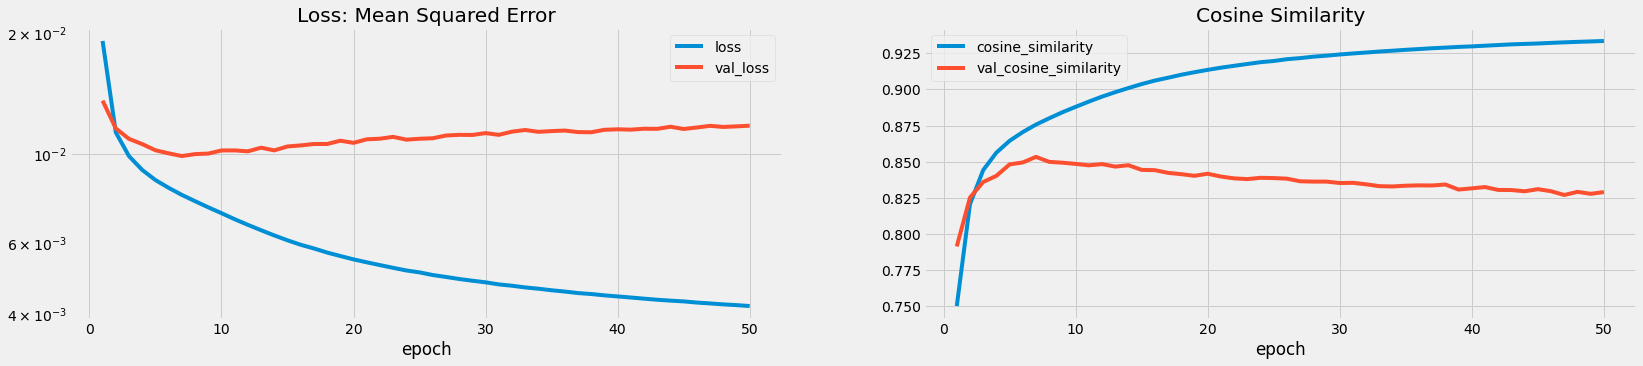

time elapsed: 1103.613273859024
loss 0.00418981583788991
cosine_similarity 0.9335322380065918
val_loss 0.011732532642781734
val_cosine_similarity 0.8290506601333618


In [62]:

with tf.device('/gpu:0'):
  history = model.fit(
      X_train_scaled,Y_train_scaled,
      epochs=50,
      batch_size = batch_size,
      validation_data=(X_test_scaled,Y_test_scaled),
      callbacks=[custom_callback],
      verbose=1
  )

print("loss",history.history['loss'][-1])
print("cosine_similarity",history.history['cosine_similarity'][-1])
print("val_loss",history.history['val_loss'][-1])
print("val_cosine_similarity",history.history['val_cosine_similarity'][-1])

## Evaluation

In [ ]:
model.evaluate(X_test_scaled,Y_test_scaled)

In [ ]:
# Y_test_pred = model.predict(np.expand_dims(X_test_scaled[:,0,:],axis=0))[0]
Y_test_pred = model.predict(x=X_test_scaled)
Y_test_true = Y_test_scaled



In [ ]:
view_length = 100
view_landmark = np.random.randint(51)
plt.title('landmark: ' + str(view_landmark))
pos = np.random.randint(len(Y_test_pred)-view_length)
plt.plot(Y_test_true[pos:pos+view_length,view_landmark], label="true")
plt.plot(Y_test_pred[pos:pos+view_length,view_landmark], label="pred")
plt.legend()


## Prediction and save the result (WIP)

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from scipy.signal import butter, sosfilt


def custom_scale(arr, a, b):
    return arr*a + b


def custom_inverse_scale(arr, a, b):
    return (arr-b)/a


# create labels
landmark_indexes = [5, 6, 7, 8, 31, 32, 33, 48,
                    49, 50, 51, 57, 58, 59, 60, 61, 62, 66, 67]
center_indexes = [8, 33, 51, 57, 62, 66]
landmark_labels = ["X_"+str(i)
                   for i in landmark_indexes if i not in center_indexes]
landmark_labels += ["Y_"+str(i) for i in landmark_indexes]
landmark_labels += ["Z_"+str(i) for i in landmark_indexes]

# mirror landmark pair
mirror_landmark_pair = [[9,7], [10,6], [11,5], [34,32], [35,31], [52,50], 
                        [53,49], [54,48], [55,59], [56,58], [63,61], [64,60], [65,67]]

# all indexes
all_indexes = [5, 6, 7, 8, 9, 10, 11, 31, 32, 33, 34, 35, 48, 49, 50, 51, 52,
               53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
                


# audio params
frame_length = 0.02  # 20ms
audio_sample_rate = 44100
hop_length = int(audio_sample_rate*frame_length)  # 882 frames for 20 ms

# import model
# saved_model_dir = "/home/alkhemi/Documents/test/"
# model = AttentionModel(num_layers=1, d_model=13, num_heads=1, 
#                          dff=512, maximum_position_encoding=10)
# temp_input = tf.random.uniform((1, 10, 13), dtype=tf.float16, minval=0, maxval=1)
# temp_output = model(x=temp_input, training=False, mask=None )
# model.load_weights(saved_model_dir+"Attention-400-0.0126-0.2547-0.3202.h5")
# model.summary()

# get scale coefs
npy_data_dir = "/home/alkhemi/Documents/thesis/npy_data/"
x_scale_coefs = np.load(npy_data_dir+"s01_x_scale_coef.npy")
y_scale_coefs = np.load(npy_data_dir+"s01_y_scale_coef.npy")

# create noise filter
sos = butter(13, [60, 8000], output='sos', btype='bandpass', fs=44100)

audio_dir = "/home/alkhemi/Documents/thesis/evaluation/test/"
audio_paths = [audio_dir +
               item for item in os.listdir(audio_dir) if item[-4:] == ".wav"]
audio_paths.sort()
# print(len(audio_paths))

output_dir = "/home/alkhemi/Documents/thesis/evaluation/test/"
filename_prefix = ""
filename_suffix = "_"+model_name

with tf.device('/gpu:0'):
  for audio_path in audio_paths:
      print("processing", audio_path)
      # load audio (mono)
      audio_array, sr = librosa.load(
          audio_path, sr=audio_sample_rate, mono=True)

      # noise filter
      audio_array_filtered = sosfilt(sos, audio_array)

      # get mfcc
      MFCCs = librosa.feature.mfcc(
          audio_array_filtered,
          sr=sr,
          n_fft=512,  # window size
          hop_length=hop_length,
          n_mfcc=13,  # num of coefficients
          n_mels=40,  # num of mel band filters
          window="hann",
          htk=True,
      ).transpose()

      # scale
      scaled_MFCCs = np.zeros(shape=MFCCs.shape, dtype="float16")
      for i in range(13):
          scaled_MFCCs[:, i] = custom_scale(
              arr=MFCCs[:, i],
              a=x_scale_coefs[i, 0],
              b=x_scale_coefs[i, 1])

      # get landmark predict
      landmarks_dis_scaled = np.zeros(shape = (scaled_MFCCs.shape[0],51), dtype='float16')
      for i in range(landmarks_dis_scaled.shape[0]-10):
        pos = i + 10
        start_time = time.time()
        landmarks_dis_scaled[pos,:] = model.predict(
            np.expand_dims(scaled_MFCCs[pos-10:pos,:], axis=0))
        print(time.time()-start_time)

      # inverse scale
      landmarks_displacement = np.zeros(
          shape=landmarks_dis_scaled.shape, dtype='float16')
      for i in range(51):
          landmarks_displacement[:, i] = custom_inverse_scale(
              arr=landmarks_dis_scaled[:, i],
              a=y_scale_coefs[i, 0],
              b=y_scale_coefs[i, 1])
      
      # create dataframe and generate other half of the face
      df = pd.DataFrame()
      # make sure all data exists
      for axis in ["X_","Y_","Z_"]:
        for i in all_indexes:
          df[axis+str(i)] = [0]*landmarks_displacement.shape[0]

      # left side landmarks
      for i in range(len(landmark_labels)):
        df[landmark_labels[i]] = landmarks_displacement[:,i]

      # the other half
      for pair in mirror_landmark_pair:
        df["X_"+str(pair[0])] = -df["X_"+str(pair[1])]
        df["Y_"+str(pair[0])] = df["Y_"+str(pair[1])]
        df["Z_"+str(pair[0])] = df["Z_"+str(pair[1])]
      
      # make sure x value of center landmark is zero
      for i in center_indexes:
        df["X_"+str(i)] = [0]*len(df)

      # save csv
      filename = audio_path.split("/")[-1].split(".")[-2]
      df.to_csv(output_dir + filename_prefix + filename + filename_suffix
                + "_pred.csv", index=False, float_format='%.3f')
      del audio_array, sr, audio_array_filtered, MFCCs, scaled_MFCCs
      del landmarks_dis_scaled, landmarks_displacement
      gc.collect()